In [11]:
# ============================================
# 1. Import Libraries
# ============================================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [12]:
# ============================================
# 2. Setup GPU (optional di Colab)
# ============================================
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [13]:
# ============================================
# 3. Data Preprocessing dan Augmentasi
# ============================================
train_path = 'dataset_test/train'
val_path = 'dataset_test/val'
test_path = 'dataset_test/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(244, 244),
    batch_size=15,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(244, 244),
    batch_size=15,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(244, 244),
    batch_size=15,
    class_mode='binary',
    shuffle=False
)

Found 2400 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 514 images belonging to 2 classes.


In [14]:
# ============================================
# 4. Transfer Learning - ResNet50V2
# ============================================
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
base_model.trainable = False  # Freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 250, 250,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 122, 122,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 124, 124,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 61, 61,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 61, 61,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 61, 61,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 61, 61,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 61, 61,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 61, 61,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 63, 63,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 61, 61,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 61, 61,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 61, 61,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 61, 61,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 61, 61,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 61, 61,    │          0 │ conv2_block1_0_c

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# ============================================
# 5. Training
# ============================================
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# ============================================
# 5.1 Visualisasi Akurasi dan Loss
# ============================================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 134s 808ms/step - accuracy: 0.8087 - loss: 0.4129 - val_accuracy: 0.9883 - val_loss: 0.0682
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 114s 711ms/step - accuracy: 0.9731 - loss: 0.0945 - val_accuracy: 0.9844 - val_loss: 0.0602
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 110s 689ms/step - accuracy: 0.9787 - loss: 0.0695 - val_accuracy: 0.9786 - val_loss: 0.0642
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 111s 693ms/step - accuracy: 0.9825 - loss: 0.0617 - val_accuracy: 0.9942 - val_loss: 0.0407
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 110s 689ms/step - accuracy: 0.9859 - loss: 0.0485 - val_accuracy: 0.9942 - val_loss: 0.0397
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 110s 688ms/step - accuracy: 0.9830 - loss: 0.0484 - val_accuracy: 0.9903 - val_loss: 0.0434
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 110s 689ms/step - accuracy: 0.9858 - loss: 0.0474 - val_accuracy: 0.9922 - val_loss: 0.0351
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 110s 687ms/step - accuracy: 0.9861 -

35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 603ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       244
           1       0.98      1.00      0.99       270

    accuracy                           0.99       514
   macro avg       0.99      0.99      0.99       514
weighted avg       0.99      0.99      0.99       514



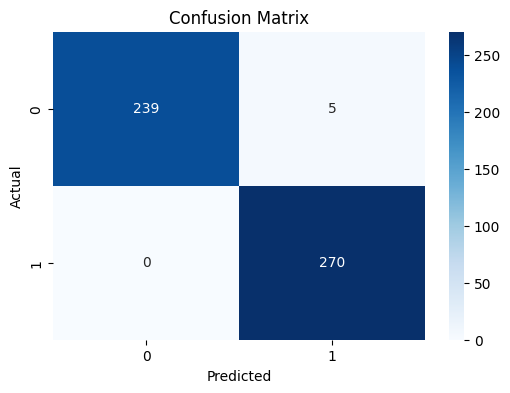

In [16]:
# ============================================
# 6. Evaluasi Model
# ============================================
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int)

print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()